#Supplemental Notebook for Lab 07

First, import the `datascience` library and some other needed resources, as we've done many times in the past.

In [1]:
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import math
from scipy import stats
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=np.VisibleDeprecationWarning)

Following the same procedure as in [Lab 6](https://github.com/DS200-SP2024-Hunter/Week06-DueFeb23), mount the google drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Then `cd` (change directory) to the correct path where the giant dataset is stored.

In [ ]:
cd /content/drive/MyDrive/Colab\ Notebooks/data

Read in the `airports.csv` dataset (small) and the `flights.csv` dataset (massive).  This takes a while.

In [4]:
airports = Table.read_table('airports.csv')
flights = Table.read_table('flights.csv')

# The code below still needs to be cleaned up:

In [ ]:
#########################################################
# DS 200, SP 2022 semester
# python code related to Lab 07 if you choose to adapt it
# If you use this code, copy-paste it one block at a time
# and try to understand what each block accomplishes
#########################################################

# Load needed python resources, including folium mapping module
from datascience import *
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np
import pandas as pd
np.set_printoptions(threshold=50)
import folium

# Read massive dataset.  Your file path may be different,
# depending on where you stored the data files for Lab 6.
file_path = 'drive/My Drive/Colab Notebooks/data/'
flights = Table.read_table(file_path + 'flights.csv')

# Read airports dataset containing airport names and lat/lon coordinates
airports = Table.read_table(file_path + 'airports.csv')

# Read airlines dataset containing airline names
airlines = Table.read_table(file_path + 'airlines.csv')
# This Table is small enough to print the whole thing:
airlines.show()

# Figure out how many flights per airline
# Notice (and try to understand!) the various methods
# used to create the new Table
count_by_airline = (flights
     .select('AIRLINE')
     .relabeled('AIRLINE', 'AIRLINE_CODE')
     .group('AIRLINE_CODE')
     .join('AIRLINE_CODE', airlines, 'IATA_CODE')
     .relabeled('AIRLINE', 'AIRLINE_NAME')
     .sort('count', descending = True)
)
# Print the table we just created
count_by_airline.show()

# Check out the columns available in the flights dataset
# Think about which might be interesting to display on a map
flights.labels

# Calculate average departure delay for each airline
# Notice (and try to understand!) the various methods
# used to create the new Table
avg_delays = (flights
     .select('AIRLINE', 'DEPARTURE_DELAY')
     .relabeled('AIRLINE', 'AIRLINE_CODE')
     .group('AIRLINE_CODE', np.nanmean)
     .relabeled('DEPARTURE_DELAY nanmean', 'AVG_DELAY')
     .join('AIRLINE_CODE', airlines, 'IATA_CODE')
     .relabeled('AIRLINE', 'AIRLINE_NAME')
     .sort('AVG_DELAY')
)
# Print the table we just created
avg_delays.show()

# As an illustration, let's consider only flights by
# American and American Eagle
AmFlights = (flights.where('AIRLINE', are.contained_in('AA MQ')))

# Count American flights for each ORIGIN_AIRPORT to get
# an idea of how many airports these airlines serve
airport_counts = AmFlights.group('ORIGIN_AIRPORT').sort('count', descending=True)
airport_counts

# Find average AIR_TIME for each ORIGIN_AIRPORT and join lat/lon info
# so that we can create a map with airport locations
avg_airtime = (AmFlights
     .select('AIR_TIME', 'ORIGIN_AIRPORT')
     .group('ORIGIN_AIRPORT', np.nanmean)
     .relabeled('AIR_TIME nanmean', 'AVG_AIRTIME')
     .join('ORIGIN_AIRPORT', airports, 'IATA_CODE')
     .join('ORIGIN_AIRPORT', airport_counts, 'ORIGIN_AIRPORT')
     .select('ORIGIN_AIRPORT', 'AVG_AIRTIME', 'AIRPORT', 'LATITUDE',
                                                'LONGITUDE', 'count')
     .relabeled('AIRPORT', 'AIRPORT_NAME')
)
# Let's see the top 10 rows of this new Table
avg_airtime

# Create folium map with circles having radius proportional to air time
AmericanAirlinesMap = folium.Map(location=[35, -100],
     tiles="OpenStreetMap", zoom_start=4,
     width='100%', height='100%')
# Add Circles one by one using info from avg_airtime Table
for i in np.arange(avg_airtime.num_rows):
     folium.Circle([avg_airtime.column('LATITUDE')[i],
     avg_airtime.column('LONGITUDE')[i]],
     radius = 250 * avg_airtime.column('AVG_AIRTIME')[i],
     fill=True).add_to(AmericanAirlinesMap)
# Once Map object is created, output it:
AmericanAirlinesMap

# Let's color the cities by how many flights:
# Use 'cut' method in pandas library to create a categorical
# variable from a numerical variable such as 'count'
count_colors = pd.cut(avg_airtime.column('count'),
     bins = [0, 10000, 25000, 50000, 100000, 200000],
     labels = ['blue', 'green', 'yellow', 'orange',
     'red'])
# Add this newly created array of colors to the Table:
avg_airtime = avg_airtime.with_column('color', count_colors)
# Check out the top ten rows of the new Table:
avg_airtime

# Recreate folium map with circles having radius proportional to air time
# But now using colors to categorize flight counts:
# blue means 1 to 10000
# green means 10001 to 25000
# yellow means 25001 to 50000
# orange means 50001 to 100000
# red means 100001 to 200000
AmericanAirlinesMap = folium.Map(location=[35, -100],
     tiles="OpenStreetMap", zoom_start=3,
     width='100%', height='100%')
# Add Circles one by one using info from avg_airtime Table
for i in np.arange(avg_airtime.num_rows):
     folium.Circle([avg_airtime.column('LATITUDE')[i],
     avg_airtime.column('LONGITUDE')[i]],
     radius = 250 * avg_airtime.column('AVG_AIRTIME')[i],
     color = avg_airtime.column('color')[i],
     fill=False).add_to(AmericanAirlinesMap)
# Once Map object is created, output it.
# This map shows both avg air time (by radius) and airport busyness (by color)
# for all airports served by American or American Eagle
AmericanAirlinesMap


# The code below is left from Lab 06:

In [ ]:
gap = 1000
start = np.random.choice(np.arange(gap))
mySample = flights.take(np.arange(start, flights.num_rows, gap))
print(mySample.num_rows)
airports = Table.read_table('airports.csv')

In [ ]:
mySample = (flights.take(np.arange(start, flights.num_rows, gap))
                   .join('ORIGIN_AIRPORT', airports, 'IATA_CODE')
                   .select('MONTH', 'DAY', 'ORIGIN_AIRPORT',
                           'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE',
                           'DEPARTURE_DELAY', 'AIRPORT',
                           'LATITUDE', 'LONGITUDE')
                   .relabeled('ORIGIN_AIRPORT', 'ORIGIN')
                   .relabeled('DESTINATION_AIRPORT', 'DESTINATION')
                   .relabeled('DEPARTURE_DELAY', 'DELAY')
                   .relabeled('AIRPORT', 'ORIGIN_NAME')
            )
print(mySample.num_rows)
mySample

In [8]:
mySample = mySample.with_column(
             'APPROX_DAY_OF_YEAR',
             30*(mySample.column('MONTH')-1) + mySample.column('DAY'))
mySample

MONTH,DAY,ORIGIN,DESTINATION,SCHEDULED_DEPARTURE,DELAY,ORIGIN_NAME,LATITUDE,LONGITUDE,APPROX_DAY_OF_YEAR
2,11,ABE,DTW,1253,212,Lehigh Valley International Airport,40.6524,-75.4404,41
3,15,ABE,ATL,1202,-10,Lehigh Valley International Airport,40.6524,-75.4404,75
9,21,ABE,DTW,1300,-6,Lehigh Valley International Airport,40.6524,-75.4404,261
12,2,ABE,ATL,600,-1,Lehigh Valley International Airport,40.6524,-75.4404,332
2,12,ABI,DFW,805,-12,Abilene Regional Airport,32.4113,-99.6819,42
4,8,ABI,DFW,705,-3,Abilene Regional Airport,32.4113,-99.6819,98
1,7,ABQ,OAK,1845,24,Albuquerque International Sunport,35.0402,-106.609,7
1,25,ABQ,LAS,1020,9,Albuquerque International Sunport,35.0402,-106.609,25
2,5,ABQ,DEN,655,-5,Albuquerque International Sunport,35.0402,-106.609,35
3,2,ABQ,ORD,1313,16,Albuquerque International Sunport,35.0402,-106.609,62


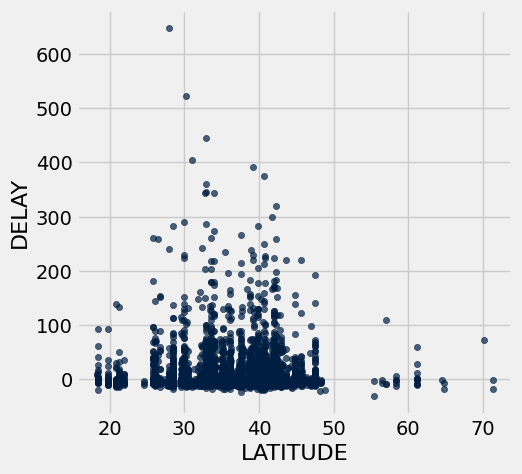

In [15]:
mySample.scatter('LATITUDE', 'DELAY')